In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


File /content/drive/MyDrive/datasets/QuickDrawImages21.h5 parsing complete
File /content/drive/MyDrive/datasets/QuickDrawImages22.h5 parsing complete
File /content/drive/MyDrive/datasets/QuickDrawImages23.h5 parsing complete
File /content/drive/MyDrive/datasets/QuickDrawImages24.h5 parsing complete
File /content/drive/MyDrive/datasets/QuickDrawImages25.h5 parsing complete
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              

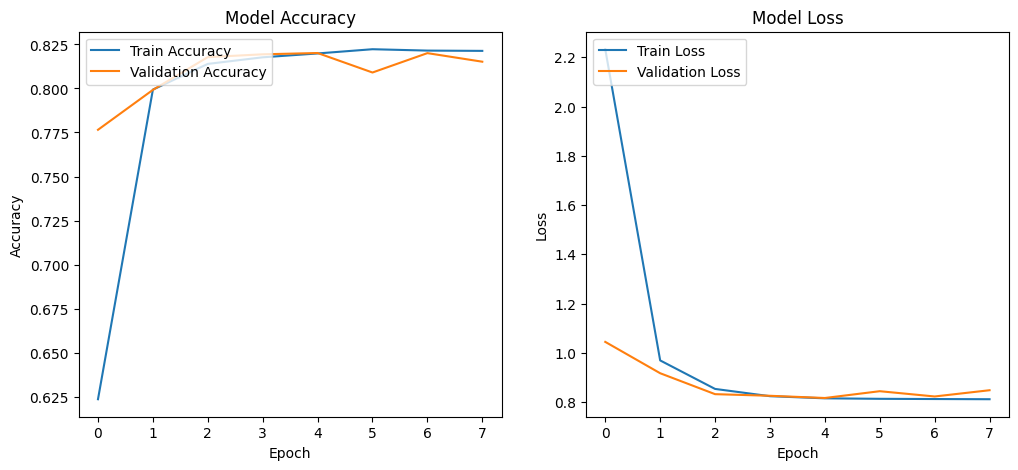

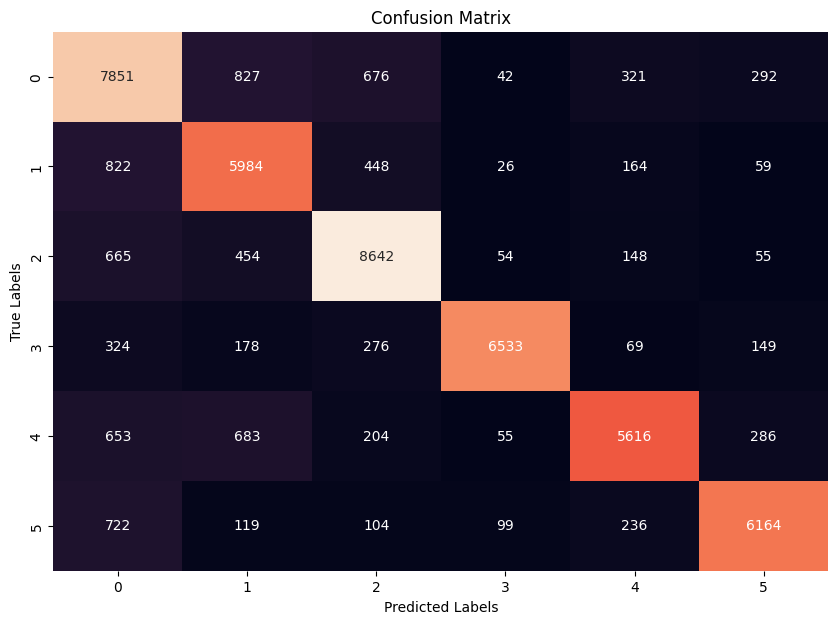

In [26]:
# First Model CNN
import h5py
import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import tensorflow.keras.utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
import io
import os
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, confusion_matrix
import math
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

h5_file_path1 = '/content/drive/MyDrive/datasets/QuickDrawImages21.h5'
h5_file_path2 = '/content/drive/MyDrive/datasets/QuickDrawImages22.h5'
h5_file_path3 = '/content/drive/MyDrive/datasets/QuickDrawImages23.h5'
h5_file_path4 = '/content/drive/MyDrive/datasets/QuickDrawImages24.h5'
h5_file_path5 = '/content/drive/MyDrive/datasets/QuickDrawImages25.h5'

desired_images = {
    "202": "onion",
    "204": "owl",
    "208": "panda",
    "212": "parrot",
    "215": "pear",
    "218": "penguin",
    "220": "pickup_truck",
    "221": "picture_frame",
    "222": "pig",
    "223": "pillow",
    "224": "pineapple",
    "226": "pliers",
    "227": "police_car",
    "231": "postcard",
    "232": "potato",
    "235": "rabbit",
    "240": "rake",
    "242": "rhinoceros",
    "245": "rollerskates",
    "248": "saw"
    }

# Category meanings
# 1: animal
# 2: bird
# 3: healthyfood
# 4: rectangle
# 5: tool
# 6: vehicle

categories = {
    "onion": 3,
    "owl": 2,
    "panda": 1,
    "parrot": 2,
    "pear": 3,
    "penguin": 2,
    "pickup_truck": 6,
    "picture_frame": 4,
    "pig": 1,
    "pillow": 4,
    "pineapple": 3,
    "pliers": 5,
    "police_car": 6,
    "postcard": 4,
    "potato": 3,
    "rabbit": 1,
    "rake": 5,
    "rhinoceros": 1,
    "rollerskates": 6,
    "saw": 5
}

# This function justifies the doodle centrally within the image
def centre_object(image):
    top_padding = 0
    bottom_padding = 0
    left_padding = 0
    right_padding = 0

    # Look for completely black rows at top and bottom
    for row in image:
        if np.sum(row) == 0:
            top_padding += 1
        else:
            break
    for row in np.flipud(image):
        if np.sum(row) == 0:
            bottom_padding += 1
        else:
            break

    # Justify image vertically
    if top_padding > bottom_padding + 1:
        to_shift = math.floor((top_padding - bottom_padding)/2)
        image = np.vstack((image[to_shift:, :], image[:to_shift, :]))
    if bottom_padding > top_padding + 1:
        to_shift = math.floor((bottom_padding - top_padding)/2)
        image = np.vstack((image[-1*to_shift:, :], image[:-1*to_shift, :]))

    # Look for completely black rows at left and right
    for col in image.T:
        if np.sum(col) == 0:
            left_padding += 1
        else:
            break
    for col in np.flipud(image.T):
        if np.sum(col) == 0:
            right_padding += 1
        else:
            break

    # Justify image horizontally
    if left_padding > right_padding + 1:
        to_shift = math.floor((left_padding - right_padding)/2)
        image = np.hstack((image[:, to_shift:], image[:, :to_shift]))
    if right_padding > left_padding + 1:
        to_shift = math.floor((right_padding - left_padding)/2)
        image = np.hstack((image[:, -1*to_shift:], image[:, :-1*to_shift]))

    return image

# This function adds the images with targets to X and y, from a h5 file with images aimed at specified targets
# There is a skip parameter - for every image that is added, that many images are skipped
def add_desired_images(file_path, target_range_start, target_range_end, images_per_target, X, y, skip=0, centre_images=False, convert_to_category=False, desired_images=desired_images):
    with h5py.File(file_path, 'r') as h5_file:
        if 'images' in h5_file:
            images_dataset = h5_file['images']
            image_index = 0
            for target in range(target_range_start, target_range_end):
                if str(target) in desired_images:
                    for i in range(images_per_target):
                        # figure += 1
                        if centre_images:
                            X.append(centre_object(images_dataset[image_index]))
                        else:
                            X.append(images_dataset[image_index])
                        if convert_to_category:
                            y.append(categories[desired_images[str(target)]])
                        else:
                            y.append(target)
                        image_index += 1 + skip
                        # If the rest of the images for the target are skipped, move to the next target
                        if image_index % images_per_target < skip:
                            break
                else:
                    image_index += images_per_target
            print(f"File {file_path} parsing complete")
        else:
            print("Image dataset not found!")
    return(X,y)

# This runs the CNN, with some preset parameters
def runCNN(X, y, input_shape, test_size=0.25, random_state=42, kernel_size=(3,3), strides=1, pool_size=(2,2), dense=128, epochs=12, l2_value=0.01):
    # # Split into training and test data
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=random_state)
    X_train = np.expand_dims(X_train, axis=3)
    X_test = np.expand_dims(X_test, axis=3)

    print(X_train[0][0])

    num_classes = y.shape[1]

    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=kernel_size, strides=1, padding='same', input_shape=input_shape, kernel_regularizer=l2(l2_value)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))

    model.add(Flatten())
    model.add(Dense(dense, activation='relu', kernel_regularizer=l2(l2_value)))
    model.add(Dense(num_classes, activation='softmax'))


    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    model.summary()


    #Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=2)

    # Train the model with a validation split and early stopping to prevent overfitting
    history = model.fit(X_train, y_train, epochs=epochs, verbose=2, validation_split=0.1, callbacks=[early_stopping])


    #Model accuracy
    y_compare = np.argmax(y_test, axis=1)
    pred_hot = model.predict(X_test)
    pred = np.argmax(pred_hot, axis=1)
    y_compare = np.argmax(y_test, axis=1)
    score = accuracy_score(y_compare, pred)
    print("Accuracy score: {}".format(score))

    #Precision and Recall
    precision = precision_score(y_compare, pred, average='macro')
    recall = recall_score(y_compare, pred, average='macro')

    #Specificity
    cm = confusion_matrix(y_compare, pred)
    specificity = np.sum(cm.diagonal()) / np.sum(cm)

    #Error Rate
    error_rate = 1 - accuracy_score(y_compare, pred)
    print("Precision: {:.2f}, Recall: {:.2f}, Specificity: {:.2f}, Error Rate: {:.2f}".format(precision, recall, specificity, error_rate))

    return model, history, y_compare, pred

# These are arrays for images and targets respectively
X = []
y = []

# # We ran an initial CNN on our doodle dataset
# X,y = add_desired_images(h5_file_path1, 200, 210, 10000, X, y, 5, False, False)
# X,y = add_desired_images(h5_file_path2, 210, 220, 10000, X, y, 5, False, False)
# X,y = add_desired_images(h5_file_path3, 220, 230, 10000, X, y, 5, False, False)
# X,y = add_desired_images(h5_file_path4, 230, 240, 10000, X, y, 5, False, False)
# X,y = add_desired_images(h5_file_path5, 240, 250, 10000, X, y, 5, False, False)
# raw_y = y
# y = tensorflow.keras.utils.to_categorical(y)
# initial_model = runCNN(X, y, (96, 96, 1))

# # We then ran a CNN after preprocessing the images centrally, leading to a 3% increase in accuracy
# X = []
# y = []
# X,y = add_desired_images(h5_file_path1, 200, 210, 10000, X, y, 5, True, False)
# X,y = add_desired_images(h5_file_path2, 210, 220, 10000, X, y, 5, True, False)
# X,y = add_desired_images(h5_file_path3, 220, 230, 10000, X, y, 5, True, False)
# X,y = add_desired_images(h5_file_path4, 230, 240, 10000, X, y, 5, True, False)
# X,y = add_desired_images(h5_file_path5, 240, 250, 10000, X, y, 5, True, False)
# raw_y = y
# y = tensorflow.keras.utils.to_categorical(y)
# preprocessed_model = runCNN(X, y, (96, 96, 1))

# We then ran a CNN which classifies objects into categories
X = []
y = []
X,y = add_desired_images(h5_file_path1, 200, 210, 10000, X, y, 0, True, True)
X,y = add_desired_images(h5_file_path2, 210, 220, 10000, X, y, 0, True, True)
X,y = add_desired_images(h5_file_path3, 220, 230, 10000, X, y, 0, True, True)
X,y = add_desired_images(h5_file_path4, 230, 240, 10000, X, y, 0, True, True)
X,y = add_desired_images(h5_file_path5, 240, 250, 10000, X, y, 0, True, True)
raw_y = y
y = tensorflow.keras.utils.to_categorical(y)


category_model, history, y_compare, pred = runCNN(X, y, (96, 96, 1))



# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 5))

# plot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# plot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

# Confusion matrix
mat = confusion_matrix(y_compare, pred)
plt.figure(figsize=(10, 7))
sns.heatmap(mat, annot=True, fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



#Second model

File /content/drive/MyDrive/datasets/QuickDrawImages21.h5 parsing complete
File /content/drive/MyDrive/datasets/QuickDrawImages22.h5 parsing complete
File /content/drive/MyDrive/datasets/QuickDrawImages23.h5 parsing complete
File /content/drive/MyDrive/datasets/QuickDrawImages24.h5 parsing complete
File /content/drive/MyDrive/datasets/QuickDrawImages25.h5 parsing complete
Accuracy: 0.71, Precision: 0.71, Recall: 0.71


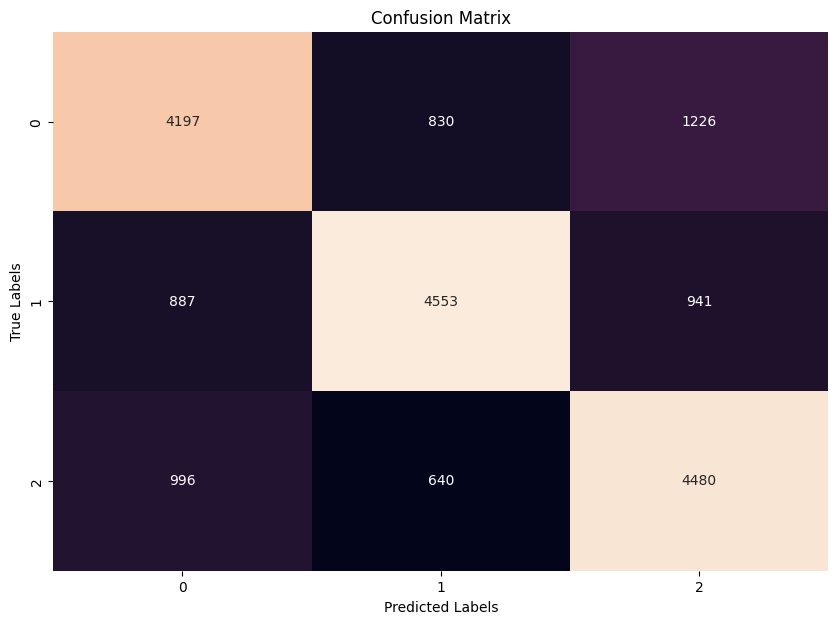

              precision    recall  f1-score   support

           1       0.69      0.67      0.68      6253
           2       0.76      0.71      0.73      6381
           3       0.67      0.73      0.70      6116

    accuracy                           0.71     18750
   macro avg       0.71      0.71      0.71     18750
weighted avg       0.71      0.71      0.71     18750



In [27]:
import h5py
import numpy as np
import math  # Importing the math module
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns

#Load the dataset
h5_file_path1 = '/content/drive/MyDrive/datasets/QuickDrawImages21.h5'
h5_file_path2 = '/content/drive/MyDrive/datasets/QuickDrawImages22.h5'
h5_file_path3 = '/content/drive/MyDrive/datasets/QuickDrawImages23.h5'
h5_file_path4 = '/content/drive/MyDrive/datasets/QuickDrawImages24.h5'
h5_file_path5 = '/content/drive/MyDrive/datasets/QuickDrawImages25.h5'

desired_images = {
    "202": "onion",
    "204": "owl",
    "208": "panda",
    "212": "parrot",
    "215": "pear",
    "218": "penguin",
    "220": "pickup_truck",
    "221": "picture_frame",
    "222": "pig",
    "223": "pillow",
    "224": "pineapple",
    "226": "pliers",
    "227": "police_car",
    "231": "postcard",
    "232": "potato",
    "235": "rabbit",
    "240": "rake",
    "242": "rhinoceros",
    "245": "rollerskates",
    "248": "saw"
    }

# Category meanings
# 1: animal
# 2: bird
# 3: healthyfood
# 4: rectangle
# 5: tool
# 6: vehicle

categories = {
    "onion": 3,
    "owl": 2,
    "panda": 1,
    "parrot": 2,
    "pear": 3,
    "penguin": 2,
    "pickup_truck": 6,
    "picture_frame": 4,
    "pig": 1,
    "pillow": 4,
    "pineapple": 3,
    "pliers": 5,
    "police_car": 6,
    "postcard": 4,
    "potato": 3,
    "rabbit": 1,
    "rake": 5,
    "rhinoceros": 1,
    "rollerskates": 6,
    "saw": 5
    }


# This function justifies the doodle centrally within the image
def centre_object(image):
    top_padding = 0
    bottom_padding = 0
    left_padding = 0
    right_padding = 0

    # Look for completely black rows at top and bottom
    for row in image:
        if np.sum(row) == 0:
            top_padding += 1
        else:
            break
    for row in np.flipud(image):
        if np.sum(row) == 0:
            bottom_padding += 1
        else:
            break

    # Justify image vertically
    if top_padding > bottom_padding + 1:
        to_shift = math.floor((top_padding - bottom_padding)/2)
        image = np.vstack((image[to_shift:, :], image[:to_shift, :]))
    if bottom_padding > top_padding + 1:
        to_shift = math.floor((bottom_padding - top_padding)/2)
        image = np.vstack((image[-1*to_shift:, :], image[:-1*to_shift, :]))

    # Look for completely black rows at left and right
    for col in image.T:
        if np.sum(col) == 0:
            left_padding += 1
        else:
            break
    for col in np.flipud(image.T):
        if np.sum(col) == 0:
            right_padding += 1
        else:
            break

    # Justify image horizontally
    if left_padding > right_padding + 1:
        to_shift = math.floor((left_padding - right_padding)/2)
        image = np.hstack((image[:, to_shift:], image[:, :to_shift]))
    if right_padding > left_padding + 1:
        to_shift = math.floor((right_padding - left_padding)/2)
        image = np.hstack((image[:, -1*to_shift:], image[:, :-1*to_shift]))

    return image

# This function adds the images with targets to X and y, from a h5 file with images aimed at specified targets
# There is a skip parameter - for every image that is added, that many images are skipped
def add_desired_images(file_path, target_range_start, target_range_end, images_per_target, X, y, skip=0, centre_images=False, convert_to_category=False, desired_images=desired_images):
    with h5py.File(file_path, 'r') as h5_file:
        if 'images' in h5_file:
            images_dataset = h5_file['images']
            image_index = 0
            for target in range(target_range_start, target_range_end):
                if str(target) in desired_images:
                    for i in range(images_per_target):
                        # figure += 1
                        if centre_images:
                            X.append(centre_object(images_dataset[image_index]))
                        else:
                            X.append(images_dataset[image_index])
                        if convert_to_category:
                            y.append(categories[desired_images[str(target)]])
                        else:
                            y.append(target)
                        image_index += 1 + skip
                        if image_index % images_per_target < skip:
                            break
                else:
                    image_index += images_per_target
            print(f"File {file_path} parsing complete")
        else:
            print("Image dataset not found!")
    return(X,y)


# Loading data
X = []
y = []
X, y = add_desired_images(h5_file_path1, 200, 210, 10000, X, y, 1, True, True)
X, y = add_desired_images(h5_file_path2, 200, 210, 10000, X, y, 1, True, True)
X, y = add_desired_images(h5_file_path3, 200, 210, 10000, X, y, 1, True, True)
X, y = add_desired_images(h5_file_path4, 200, 210, 10000, X, y, 1, True, True)
X, y = add_desired_images(h5_file_path5, 200, 210, 10000, X, y, 1, True, True)


# Flatten image data for Random Forest
X_flattened = [image.flatten() for image in X]
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.25, random_state=42)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred = rf_classifier.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))


In [ ]:
pool_size=(2, 2)
X = np.array(X)
y = np.array(y)
# pooled_X = block_reduce(X, 3, np.max)
# flattened_images = [image.reshape(image.shape[0], -1) for image in pooled_X]
flattened_images = X.reshape(X.shape[0], -1)
kmeans = KMeans(n_clusters=6, random_state=42)
y_kmeans = kmeans.fit_predict(flattened_images)
centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

converted_y = [str(categories[desired_images[str(t)]]) for t in raw_y]
str_y_kmeans = [str(i) for i in y_kmeans]
cm = confusion_matrix(converted_y, str_y_kmeans)

#using seaborn
sns.heatmap(cm, square=True, annot=True, cbar=False)
plt.xlabel('Actual category')
plt.ylabel('Assigned cluster')
plt.show()
fig, axs = plt.subplots(2, 6, figsize=(15, 5))
# Plot original images
for i in range(1,7):
    original_image = X[y_kmeans == i][0]  # Take the first image in each cluster
    axs[0, i].imshow(original_image, cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title(f'Original {i + 1}')
# Plot clustered centres
for i in range(1,7):
    clustered_center = centers[i].reshape(X.shape[1:])  # Reshape to original image shape
    axs[1, i].imshow(clustered_center, cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title(f'Cluster Center {i + 1}')
plt.show()